In [1]:
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd

def unPackDenFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=4)
    distance = y[:,0]
    gas_density  = y[:,1]

   
    return distance, gas_density
def unPackRawFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
   
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity
import scipy as sp
import scipy.interpolate
import matplotlib.pyplot as plt

In [2]:
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    data = []
    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        den_path =  'los.00' + '{0:03}'.format(i) +'.den'
        distance, pec_vel, temp, HI_density, gas_density2, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance1,gas_density1 = unPackDenFile(den_path)
        distance_cm = distance *0.1452*3.086e24 /0.68
        gas_density =sp.interpolate.interp1d(distance1,gas_density1, fill_value="extrapolate")(distance)
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k+1
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k +1
                        if(k<len(distance)-1):
                            k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(area_under >= (1.6*10**17)and area_under  <= (10**22)):
                        data.append(area_under)
    return data
lyman_limited_value = lyman_identification()


In [3]:
##the a-axis is the number of lyman-limited series, y-axis is the column density
lyman_limited_value_sorted = sorted(lyman_limited_value)
#below shows the total of lyman_limited_value in the nlos

In [4]:
##need to bin the data, and graph it like the paper.
##right here we are goin go bin the data, using panda
##find the max/min

min_value_lyman_limited_value = np.log10(min(lyman_limited_value_sorted))
max_value_lyman_limited_value = np.log10(max(lyman_limited_value_sorted))
print(min_value_lyman_limited_value)
print(max_value_lyman_limited_value)

17.204430527726725
21.954810463388316


In [5]:
##putting data into panda data_frame for better organization
##belows is the bin value
bins = np.linspace(min_value_lyman_limited_value,max_value_lyman_limited_value,51)
bins

array([17.20443053, 17.29943813, 17.39444573, 17.48945332, 17.58446092,
       17.67946852, 17.77447612, 17.86948372, 17.96449132, 18.05949892,
       18.15450651, 18.24951411, 18.34452171, 18.43952931, 18.53453691,
       18.62954451, 18.72455211, 18.81955971, 18.9145673 , 19.0095749 ,
       19.1045825 , 19.1995901 , 19.2945977 , 19.3896053 , 19.4846129 ,
       19.5796205 , 19.67462809, 19.76963569, 19.86464329, 19.95965089,
       20.05465849, 20.14966609, 20.24467369, 20.33968129, 20.43468888,
       20.52969648, 20.62470408, 20.71971168, 20.81471928, 20.90972688,
       21.00473448, 21.09974207, 21.19474967, 21.28975727, 21.38476487,
       21.47977247, 21.57478007, 21.66978767, 21.76479527, 21.85980286,
       21.95481046])

In [6]:
##divide up the data 
bin_data = pd.DataFrame()
bin_data['cut_lyman_limited'] = np.array(lyman_limited_value_sorted)
bin_data['cut_lyman_limited'] = pd.cut(np.log10(bin_data['cut_lyman_limited']), bins = bins,include_lowest = True).astype(str)

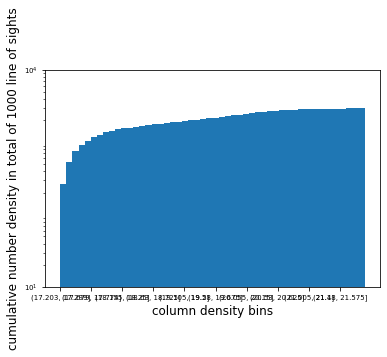

<Figure size 640x480 with 0 Axes>

In [7]:
##graph similar to the paper, culmulative
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
hist = ax.hist(bin_data,bins=50,cumulative =1,log =True)
ax.set_xticks(ax.get_xticks()[::5])
ax.set_yticks(ax.get_yticks()[::3])
ax.set_xlabel('column density bins', fontsize=12)
ax.set_ylabel('cumulative number density in total of 1000 line of sights', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=7)
plt.figure(figsize=(8, 6), dpi=80)
plt.show()

In [8]:
##extract the change in column density counts
##abserve the trend that as the column density decreases the rate of number density decrease increase.
number_count = []
for i in range(1, len(hist[0])):
    number_count.append(hist[0][i]- hist[0][i-1])
total =0 
for i in number_count:
    total += i

In [9]:
#we here find the change in column density
#d_N_column = bins[1] - bins[0]
d_N_column= []
for i in range(1,50):
    d_N_column.append(10**bins[i]-10**bins[i-1])


In [10]:
def aH_calc(aexp,OmegaM):
    aH = 100*aexp*np.sqrt(OmegaM/aexp**3+(1-OmegaM))
    return aH
aH = aH_calc(aexp=0.1433,OmegaM=0.3036)
print(aH)

146.04563456166113


In [11]:
#dN / (dz *dN_HI)
y_value = []
#dz = dv/c = H*dr/c = H*a*dx/c
#dx = 200cMpc * number of line of sights
dz = aH*(200*1000)/(3e5) 
for i,k in zip(number_count,d_N_column):
    if(number_count == 0):
        y_value.append(0)
    y_value.append(i/(dz*(k)))
print(dz)

97.36375637444075


In [12]:
x_value = []
for i in range(1,50):
    x_value.append(bins[i])

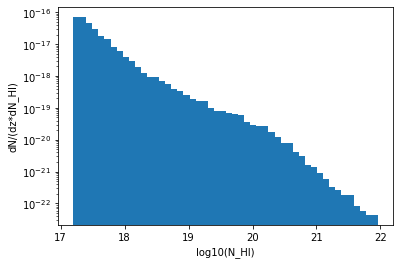

In [13]:
plt.bar(x_value,y_value,width = 0.2)
plt.xlabel("log10(N_HI)")
plt.ylabel("dN/(dz*dN_HI)")
plt.yscale('log')


In [14]:

lyman_limited_value_sorted = list(reversed(lyman_limited_value_sorted))

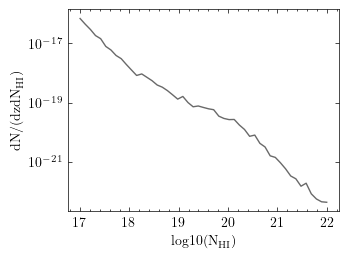

In [18]:
import matplotlib.pyplot as plt
import pickle as pickle
with open('y_value_80_uniform.pkl', 'wb') as f:
    pickle.dump(y_value, f, protocol=pickle.HIGHEST_PROTOCOL)
x_axis = np.linspace(17,22,49)
with plt.style.context('science','notebook'):
    plt.figure()    
    plt.plot(x_axis,y_value,color = "dimgray")
    plt.rcParams['font.size'] = 8
    plt.yscale("log") 
    plt.yticks()
    plt.xlabel("$\mathrm{log10(N_{HI})}$",fontsize = 10)
    plt.ylabel("$\mathrm{dN/(dzdN_{HI})}$",fontsize =10,)
    plt.savefig("f1_uniform_80.pdf")